In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import networkx as nx
import csv
from tqdm import tqdm

In [3]:
def nclusters(data, threshold):
    data = [float(el) for el in data]
    data = sorted(data)
    start = data[0]
    max_val = start + threshold
    c = (start, max_val)
    cluster = dict()
    for i in data:
        if i <= max_val:
            if c in cluster.keys():
                cluster[c] += 1
            else:
                cluster[c] = 1
        else:
            max_val = i + threshold
            c = (i, max_val)
            cluster[c] = 1
    #ora ho il dizionario con i cluster di una run
    C_num = len(data)**2
    C_den = 0
    for k in cluster.keys():
        C_den += cluster[k]*cluster[k]
    C = C_num / C_den
    return C

In [4]:
def read_snapshot(filename):
    G = nx.Graph()
    with open(filename, 'r') as edgelistfile:
        data = csv.reader(edgelistfile)
        for row in data:
            G.add_node(int(row[0])) #superhero in first column
            G.add_node(int(row[1])) #superhero in second column
            G.add_edge(int(row[0]), int(row[1]), weight = 1)
        return G

def read_opinions(filename):
    colors = []
    with open(filename) as infile:
        opinions = infile.readlines()
    opinions = [float(op.strip()) for op in opinions]
    for op in opinions:
        if op < 0.4:
            colors.append("red")
        elif op >= 0.4 and op <= 0.6:
            colors.append("green")
        else:
            colors.append("blue")
    return opinions, colors
    

def add_opinions(graph, opinions):
    for node in graph.nodes:
        graph.nodes[node]['opinion'] = opinions[node]

    return graph

def compute_ncc(graph):
    return nx.number_connected_components(graph)


  0%|          | 0/100001 [00:00<?, ?it/s]

triangles rewiring er0.1 pr0.0 e0.2 g0.0 mi100000


 15%|█▌        | 15121/100001 [05:19<29:55, 47.29it/s]  


KeyboardInterrupt: 

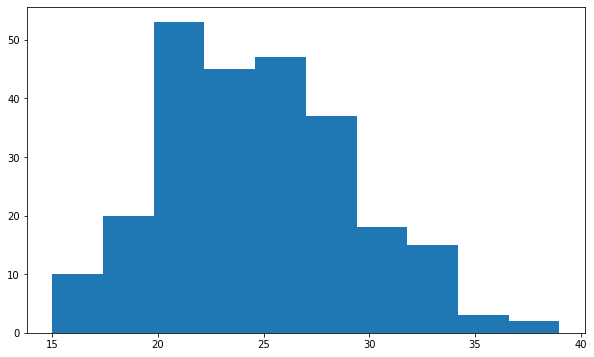

In [5]:
import sys
sys.path.append("/home/pansanella/mydata/GitHub/local_packages/")
sys.path.append("/data1/users/pansanella/mydata/GitHub/local_packages/")
sys.path.append("/data1/users/pansanella/mydata/GitHub/local_packages/netdspatch_local/")
import networkx as nx
import ndlib_local.ndlib.models.ModelConfig as mc
import ndlib_local.ndlib.models.opinions as op
import warnings
import tqdm
import os
import numpy as np
from matplotlib.offsetbox import AnchoredText

warnings.filterwarnings("ignore")


def iteration_bunch(model, name, niterations=10, node_status=True, progress_bar=True):
    if not os.path.exists(f"snapshotGraphs nuovi/triangles rewiring/{name}/"):
        os.mkdir(f"snapshotGraphs nuovi/triangles rewiring/{name}/")
    system_status = []
    params = name.split(' ')
    for it in tqdm.tqdm(range(0, niterations), disable=not progress_bar):    
        # print(it)        
        its = model.iteration(node_status)
        system_status.append(its)
        save_snapshots_for = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 500, 1000, 5000, 10000, 100000]
        if it in save_snapshots_for:
            
            fig, ax = plt.subplots(1, 1, num=1, figsize=(10, 8))
            G = model.graph.graph
            pos = nx.spring_layout(G, seed=1)  # positions for all nodes
            nx.draw(G, pos, node_color=list(its['status'].values()), cmap=plt.cm.RdBu, node_size=80.0, vmin=0.0, vmax=1.0, width=0.1, alpha=1.0, ax = ax)
            plt.title(f"Network at time {it}")
            plt.tight_layout()
            sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu, norm=plt.Normalize(vmin = 0, vmax=1))
            sm._A = []
            cbar = plt.colorbar(sm)
            for t in cbar.ax.get_yticklabels():
                t.set_fontsize(10)
            cbar.outline.set_visible(False)
            cbar.ax.tick_params()
            opinions = list(its['status'].values())
            C = nclusters(opinions, 0.1)
            at = AnchoredText(
                f"C={C}", prop=dict(size=15), frameon=True, loc='lower left')
            at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            ax.add_artist(at)
            plt.savefig(f"snapshotGraphs nuovi/triangles rewiring/{name}/network {it}")
            plt.close()

            fig, ax = plt.subplots(1, 1, num=1, figsize=(10, 6))
            degrees = [G.degree(n) for n in G.nodes()]
            plt.hist(degrees)
            plt.savefig(f"snapshotGraphs nuovi/triangles rewiring/{name}/degreedist {it}")
            plt.close()
            
            nx.write_edgelist(G, f"snapshotGraphs nuovi/triangles rewiring/{name}/edgelist {it} new.csv", delimiter=",")
            with open(f"snapshotGraphs nuovi/triangles rewiring/{name}/opinions {it} new.txt", "w") as opfile:
                for op in list(np.array(list(its['status'].values()))):
                    opfile.write(str(op)+"\n")
        # return system_status


n = 250
max_it = 100000

for graphname in ['er']:
    if graphname == 'er':
        p = 0.1
        graph = nx.erdos_renyi_graph(n, p)
    else:
        p = 5
        graph = nx.barabasi_albert_graph(n, p)
    for pr in [0.0,0.5]:
        for e in [0.2]:
            for g in [0.0,0.5]:
                name = f"triangles rewiring {graphname}{p} pr{pr} e{e} g{g} mi{max_it}"
                print(name)
                model = op.AdaptivePeerPressureAlgorithmicBiasModel(graph)
                config = mc.Configuration()
                config.add_model_parameter("epsilon", e)
                config.add_model_parameter("gamma", g)
                config.add_model_parameter("p", pr)
                model.set_initial_status(config)
                status = iteration_bunch(model, name, niterations=100001, node_status=True, progress_bar=True)            

In [ ]:
# from matplotlib import cm
# import numpy as np
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# # top = cm.get_cmap('Reds_r', 128) # r means reversed version
# # center1 = cm.get_cmap('Greens', 128)
# # center2 = cm.get_cmap('Greens_r', 128)
# # bottom = cm.get_cmap('Blues', 128)# combine it all
# # newcolors = np.vstack((top(np.linspace(0, 1, 128)),
# #                         center1(np.linspace(0,1,128)),
# #                         center2(np.linspace(0,1,128)),
# #                        bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
# # mia = ListedColormap(newcolors, name='mia')

# # Red, Green, Blue
# # N = 256
# # vals = np.ones((N, 4))
# # # Red stays constant until middle of colormap all other channels increas
# # # to result in white
# # # from middle of colormap we decrease to 0, 0, 255 which is blue
# # vals[:, 0] = np.concatenate((np.linspace(1, 1, N//2), np.linspace(1, 0, N//2)), axis=None)
# # vals[:, 1] = np.concatenate((np.linspace(0, 1, N//2), np.linspace(1, 0, N//2)), axis=None)
# # vals[:, 2] = np.concatenate((np.linspace(0, 1, N//2), np.linspace(1, 1, N//2)), axis=None)
# # mia = ListedColormap(vals)

# colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
# n_bins = 100  # Discretizes the interpolation into bins
# cmap_name = 'mia'
# mia = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

In [ ]:
infos = []
models = ["rewiring"]
graphs = ["er","ba"]
pr = 0.5
epss = [0.2]
gams = [0.5]
mi = 100000
for model in models:
    for graph in graphs:
        if graph == "er":
            p = 0.1
        else:
            p = 5
        for eps in epss:
            for gam in gams:    
                dirname = f"snapshotGraphs/{model}/{model} {graph}{p} pr{pr} e{eps} g{gam} mi{mi}/"
                for nit in range(100000):
                    try:
                        filename = f"edgelist {nit}.csv"
                        opfile = 'opinions '+str(nit)+'.txt'
                        opinions, colors = read_opinions(os.path.join(dirname, opfile))
                        print("avg opinion is ", sum(opinions)/len(opinions))
                        C = nclusters(opinions, 0.01)
                        print("avg_ncluster is ", C)
                        g = read_snapshot(os.path.join(dirname, filename))
                        pos = nx.spring_layout(g, seed=1)  # positions for all nodes
                        g = add_opinions(g, opinions)
                        nx.draw(g, pos, node_color=opinions, cmap=plt.cm.RdBu, node_size=60.0, vmin=0.0, vmax=1.0, width=0.1, alpha=1.0)
                        plt.title(f"{model}_{graph}_{pr}_{eps}_{gam}_{nit}")
                        sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu, norm=plt.Normalize(vmin = 0, vmax=1))
                        sm._A = []
                        cbar = plt.colorbar(sm)
                        for t in cbar.ax.get_yticklabels():
                            t.set_fontsize(10)
                        cbar.outline.set_visible(False)
                        cbar.ax.tick_params()
                        plt.show()
                        plt.close()
                    except:
                        
                        continue
                    # nc = compute_ncc(g)
                    # d['nit'] = nit
                    # d['nc'] = nc
                    # infos.append(d)
                else:
                    continue
# import pandas as pd
# results = pd.DataFrame(infos)
# results.to_csv(f"connected_components_{model}.csv")
# %matplotlib inline
# for eps in [0.2, 0.3, 0.4]:
#     for gam in [0.0, 0.5, 1.0, 1.5]:
#         data = results[results['graph']=='er']
#         data2 = data[data['eps']==eps]
#         data3 = data2[data2['gam'] == gam]
#         sns.lineplot(data=data, x="nit", y="nc", marker = "s")
#         plt.title('_'.join([model, str(eps), str(gam)]))
#         plt.show()

In [ ]:
infos = []
models = ["triangles rewiring"]
graphs = ["er", "ba"]
pr = 0.5
epss = [0.2, 0.3, 0.4]
gams = [0.0, 0.5, 1.0, 1.5]
mi = 100000
for model in models:
    for graph in graphs:
        if graph == "er":
            p = 0.1
        else:
            p = 5
        for eps in epss:
            for gam in gams:    
                dirname = f"snapshotGraphs/{model}/{model} {graph}{p} pr{pr} e{eps} g{gam} mi{mi}/"
                for filename in os.listdir(f"{dirname}/"):
                    if filename.startswith('edgelist'):
                        d = {'model':model, 'graph':graph, 'p':p, 'pr':pr, 'eps':eps, 'gam':gam, 'mi':mi}
                        nit = int((filename.split(' ')[1]).split('.')[0])
                        opfile = 'opinions '+str(nit)+'.txt'
                        opinions, colors = read_opinions(os.path.join(dirname, opfile))
                        g = read_snapshot(os.path.join(dirname, filename))
                        g = add_opinions(g, opinions)
                        nc = compute_ncc(g)
                        d['nit'] = nit
                        d['nc'] = nc
                        infos.append(d)
                    else:
                        continue
import pandas as pd
results = pd.DataFrame(infos)
results.to_csv(f"connected_components_{model}.csv")

%matplotlib inline
for eps in [0.2, 0.3, 0.4]:
    for gam in [0.0, 0.5, 1.0, 1.5]:
        data = results[results['graph']=='er']
        data2 = data[data['eps']==eps]
        data3 = data2[data2['gam'] == gam]
        sns.lineplot(data=data, x="nit", y="nc", marker = "s")
        plt.title('_'.join([model, str(eps), str(gam)]))
        plt.show()

In [ ]:
models = ["rewiring"]
graphs = ["er", "ba"]
pr = 0.5
epss = [0.2, 0.3, 0.4]
gams = [0.0, 0.5, 1.0, 1.5]
mi = 100000
def plot_degree_dist(G, ax):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, ax = ax)
%matplotlib inline
for model in models:
    for graph in graphs:
        if graph == "er":
            p = 0.1
        else:
            p = 5
        for eps in epss:
            for gam in gams:    
                dirname = f"snapshotGraphs/{model}/{model} {graph}{p} pr{pr} e{eps} g{gam} mi{mi}/"
                for nit in range(100000):
                    try:
                        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 7), dpi=600)
                        filename = f"edgelist {nit}.csv"
                        opfile = 'opinions '+str(nit)+'.txt'
                        opinions, colors = read_opinions(os.path.join(dirname, opfile))
                        print("avg opinion is ", sum(opinions)/len(opinions))
                        C = nclusters(opinions, 0.01)
                        print("avg_ncluster is ", C)
                        g = read_snapshot(os.path.join(dirname, filename))
                        pos = nx.spring_layout(g, seed=1)  # positions for all nodes
                        g = add_opinions(g, opinions)
                        nx.draw(g, pos, node_color=opinions, cmap=plt.cm.RdBu, node_size=60.0, vmin=0.0, vmax=1.0, width=0.1, alpha=1.0, ax=axes[0])
                        plot_degree_dist(g, ax=axes[1])
                        plt.sup_title(f"{model}_{graph}_{pr}_{eps}_{gam}_{nit}")
                        plt.show()
                    except:
                        
                        continue
                    # nc = compute_ncc(g)
                    # d['nit'] = nit
                    # d['nc'] = nc
                    # infos.append(d)
                else:
                    continue



In [ ]:
def heatmapsplotdeffuant(results, measure, modelname, fs):

    params = ['graph','nruns','n', 'k','gam','eps', 'pr']
    paramsnames = ['graph', 'nruns', 'n', 'k', '$\gamma$', '$\epsilon$', '$p_r$']
    parmapping = dict(zip(params, paramsnames))

    sns.set_style("whitegrid")
    sns.set(font_scale=fs)

    with sns.axes_style("whitegrid"):

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6.3), dpi=600, sharey=True, sharex=True)
        fmt = ".2f"
        annot = True
        if measure=='avg_niter':
            annot=False

        list_of_labels = ["a", "b", "c", "d", "e", "f", "g", "h", "i"]
        lab = 0
        i = 0
        for val in ["er", "ba"]:
            data = results[results['gam']==0.0]
            data2 = data[data["graph"] == val]
            df = data2.pivot("eps", "pr", measure)
            a=sns.heatmap(df, vmin=min(data[measure]), vmax=max(data[measure]), cmap='RdBu_r', cbar=False, fmt=fmt, annot=annot, ax= axes[i])
            axes[i].set_xlabel(r'{}'.format(parmapping["pr"]), fontsize=20)
            axes[i].set_title(r'({}) {}'.format(list_of_labels[lab], val.upper()), fontsize=20, pad=20)
            axes[i].set_ylabel('')
            lab +=1
            i+=1
        axes[0].set_ylabel(r'{}'.format(parmapping["eps"]), fontsize=25)
        axes[0].invert_yaxis()

        for ax in axes.flat:
            ax.tick_params(axis='x', which='major', pad=-2)
            ax.tick_params(axis='y', which='major', pad=-2)
        cax = fig.add_axes([0.92, 0.22, 0.01, 0.6])
        cbar = fig.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(10)
        cbar.outline.set_visible(False)
        cbar.ax.tick_params()
        plt.savefig("plots/aggregate/hm deffuant {} gr0.0 {}.png".format(modelname, measure))
        plt.close()


In [ ]:
def lineplotdeffuant(results, measure, modelname):
    
    params = ['graph','nruns','n', 'k','gam','eps', 'pr']
    paramsnames = ['graph', 'nruns', 'n', 'k', '$\gamma$', '$\epsilon$', '$p_r$']
    parmapping = dict(zip(params, paramsnames))

    sns.set_style("whitegrid")
    sns.set(font_scale=0.8)

    values_to_plot = sorted(list(results["graph"].unique()))

    with sns.axes_style("whitegrid"):

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6.3), dpi=600)
        fmt = ".2f"
        annot = True
        if measure=='avg_niter':
            fmt = ".0f"

        list_of_labels = ["a", "b", "c", "d", "e", "f", "g", "h", "i"]
        lab = 0
        i = 0
        for val in values_to_plot:
            data = results[results['gam']==0.0]
            data2 = data[data["graph"] == val]
            im = sns.lineplot(data=data2, x="pr", y=measure, hue="eps", markers=True, ax=ax)
            im.fill_between(data2['pr'], data2[measure]-data2['std_ncluster_01'], dataset.upper, alpha=0.2)

            
#             df = data2.pivot("eps", "pr", measure)
#             a=sns.heatmap(df, vmin=min(data[measure]), vmax=max(data[measure]), cmap='RdBu_r', cbar=False, fmt=fmt, annot=annot, ax= axes[i])
#             axes[i].set_ylabel(r'{}'.format(parmapping["eps"]), fontsize=10)
#             axes[i].set_xlabel(r'{}'.format(parmapping["pr"]), fontsize=10)
#             axes[i].set_title(r'({}) {}'.format(list_of_labels[lab], val))
#             lab +=1
#             i+=1
#         for ax in axes.flat:
#             ax.tick_params(axis='x', which='major', pad=-2)
#             ax.tick_params(axis='y', which='major', pad=-2)
#         cax = fig.add_axes([0.92, 0.22, 0.01, 0.6])
#         cbar = fig.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")
#         for t in cbar.ax.get_yticklabels():
#             t.set_fontsize(10)
#         cbar.outline.set_visible(False)
#         cbar.ax.tick_params()
#         plt.show()
#         plt.close()



In [ ]:
#rifare i plot dal fisso e mettere le label in latex per paper
def heatmapsplot(results, measure, modelname, x='pr', y='gam', grouping="eps"):

    params = ['graph','nruns','n', 'k','gam','eps', 'pr']
    paramsnames = ['graph', 'nruns', 'n', 'k', '$\gamma$', '$\epsilon$', '$p_r$']
    parmapping = dict(zip(params, paramsnames))

    sns.set_style("whitegrid")
    sns.set(font_scale=1.2)

    values_to_plot = sorted(list(results[grouping].unique()))

    with sns.axes_style("whitegrid"):

        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6.3), dpi=600)
        fmt = ".2f"
        annot = True
        if measure=='avg_nit' or measure=="std_nit":
            fmt = ".0f"
            annot=False

        list_of_labels = ["a", "b", "c", "d", "e", "f", "g", "h", "i"]
        lab = 0
        i = 0
        for val in values_to_plot:
            data = results[results["graph"]=="er"]
            data = data[data[grouping] == val]
            df = data.pivot(x, y, measure)
            a=sns.heatmap(df, vmin=min(results[measure]), vmax=max(results[measure]), cmap='RdBu_r', cbar=False, fmt=fmt, annot=annot, ax= axes[0, i])
            axes[0, i].set_ylabel(r'{}'.format(parmapping[x]), fontsize=15)
            axes[0, i].set_xlabel(r'{}'.format(parmapping[y]), fontsize=15)
            axes[0, i].set_title(r'({}) ER $\epsilon$ = {}'.format(list_of_labels[lab], val), fontsize=15)
            lab +=1
            i+=1

        i = 0
        for val in values_to_plot:
            data = results[results["graph"]=="ba"]
            data = data[data[grouping] == val]
            df = data.pivot(x, y, measure)
            sns.heatmap(df, vmin=min(results[measure]), vmax=max(results[measure]), cmap='RdBu_r', cbar=False, fmt=fmt, annot=annot, ax= axes[1, i])
            axes[1, i].set_ylabel(r'{}'.format(parmapping[x]), fontsize=15)
            axes[1, i].set_xlabel(r'{}'.format(parmapping[y]), fontsize=15)
            axes[1, i].set_title(r'({}) BA $\epsilon$ = {}'.format(list_of_labels[lab], val), fontsize=15)
            i+=1
            lab+=1
        for ax in axes.flat:
            ax.tick_params(axis='x', which='major', pad=-2)
            ax.tick_params(axis='y', which='major', pad=-2)
        cax = fig.add_axes([0.92, 0.22, 0.01, 0.6])
        cbar = fig.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(10)
        cbar.outline.set_visible(False)
        cbar.ax.tick_params()
        plt.subplots_adjust(left=0.05, hspace=0.5)
        # plt.tight_layout()
        plt.savefig("plots/hm {} gr0.0 {}.png".format(modelname, measure))
        plt.show()
        plt.close()

In [ ]:
def from_res_to_iterations(name, nr):
    res = open("res/new/{} nr{}.csv".format(name, nr))
    iterations = []
    it = 0
    for line in res.readlines():
        iterations.append(dict())
        iterations[it]['iteration'] = it
        iterations[it]['status'] = dict()

        opinions = line.strip().split(',')

        for i in range(len(opinions)):
            iterations[it]['status'][i] = float(opinions[i])
            iterations[it]['node_count'] = {0: 0},
            iterations[it]['status_delta'] = {0: 0}

        it += 1
        
    return iterations

In [ ]:
def evolution(iterations, fig, ax):

    """
    Generates the plot

    :param filename: Output filename
    :param percentile: The percentile for the trend variance area
    """

    nodes2opinions = {}
    node2col = {}

    last_it = iterations[-1]['iteration'] + 1
    last_seen = {}

    for it in iterations:
        sts = it['status']
        its = it['iteration']
        for n, v in sts.items():
            if n in nodes2opinions:
                last_id = last_seen[n]
                last_value = nodes2opinions[n][last_id]

                for i in range(last_id, its):
                    nodes2opinions[n][i] = last_value

                nodes2opinions[n][its] = v
                last_seen[n] = its
            else:
                nodes2opinions[n] = [0]*last_it
                nodes2opinions[n][its] = v
                last_seen[n] = 0
                if v < 0.33:
                    node2col[n] = '#3776ab'
                elif 0.33 <= v <= 0.66:
                    node2col[n] = '#FFA500'
                else:
                    node2col[n] = '#FF0000'

    mx = 0
    for k, l in future.utils.iteritems(nodes2opinions):
        if mx < last_seen[k]:
            mx = last_seen[k]
        x = list(range(0, last_seen[k]))
        y = l[0:last_seen[k]]
        ax.plot(x, y, lw=1, alpha=0.25, color=node2col[k])
    
    ax.set_ylim(-0.1, 1.1)
    # ax.set_xlim(0, 1000)
    ax.tick_params(axis='both', which='major', labelsize=4, pad=0)                
    # plt.grid(axis = 'both', which='both')
    # plt.tight_layout()
    fig.savefig(f"plots/evolution {name} nr{nr}.png")



def finaldistribution(name, nr, ax):
    sns.set_style("whitegrid")
    jsonfile = open(f'finals/final_opinions {name}.json')
    data = json.load(jsonfile)
    finalops = list(data[str(nr)])
    x = [i for i in range(100)]
    y = sorted(finalops)    
    node2col = {}
    for node in x:
        if y[node] < 0.33:
            node2col[node] = '#3776ab'
        elif 0.33 <= y[node] <= 0.66:
            node2col[node] = '#FFA500'
        else:
            node2col[node] = '#FF0000'
    for node in x:
        ax.scatter(x[node], y[node], s = 0.2, c = node2col[node])
    ax.set_ylim(-0.1, 1.1)
    ax.tick_params(axis='both', which='major', labelsize=3, pad=2)    
    ax.set_ylabel(r'$opinion$', fontsize=3)
    ax.set_xlabel(r'$node$', fontsize=3)
    plt.grid(axis = 'both', which='both')
    plt.tight_layout()

In [ ]:
from tqdm import tqdm
def spaghettigridbye(results, modelname, gams, prs, epss):
    for graph in ["er", "ba"]:
        if graph == "er":
            p = 0.1
        else:
            p=5
        for e in epss:
            if not os.path.exists(f"plots/new/evolutiongrid {modelname} {graph}{p} gr0.0 e{e} mi100000.png"):
                with tqdm(total=len(prs)*len(gams)) as pbar:
                    fig, axes = plt.subplots(nrows=len(prs), ncols=len(gams), figsize=(len(gams), len(prs)), dpi=600, sharey=True)
                    row=0
                    for pr in prs:
                        col=0
                        for g in gams: 
                            name = f'{modelname} {graph}{p} pr{pr} e{e} g{g} gr{0.0} mi100000'
                            nr = 1
                            iterations = from_res_to_iterations(name, nr)
                            evolution(iterations, fig=fig, ax=axes[row,col])
                            col+=1
                            pbar.update(1)
                        row+=1
                    plt.savefig(f"plots/new/evolutiongrid {modelname} {graph}{p} gr0.0 e{e} mi100000.png")
                    plt.close()

In [ ]:
def finaldistributiongridbye(results, modelname, gams, prs, epss):
    graphs = ['er', 'ba']
    sns.set_style("whitegrid")
    for graph in graphs:
        if graph == "er":
            p = 0.1
        else:
            p = 5
        for e in epss:
            if not os.path.exists(f"plots/distributiongrid {modelname} {graph}{p} e{e} mi100000.png"):
                with tqdm(total=len(prs)*len(gams)) as pbar:
                    fig, axes = plt.subplots(nrows=len(prs), ncols=len(gams), figsize=(len(gams), len(prs)), dpi=600, sharey=True)
                    row=0
                    for pr in prs:
                        col=0
                        for g in gams:     
                            name = f'{modelname} {graph}{p} pr{pr} e{e} g{g} mi100000'
                            finaldistribution(name, 1, axes[row, col])
                            col+=1
                            pbar.update(1)
                        row+=1
                    name = f'{modelname} {graph}{p} e{e}'
                    plt.savefig(f"plots/distributiongrid {modelname} {graph}{p} e{e} mi100000.png")
                    plt.close()

In [ ]:
modelname = "triangles rewiring"
gr = 0.0
finalfile = f"{modelname} results final new.csv"

In [ ]:
results = pd.read_csv(f"finals/{finalfile}", index_col=[0])

In [ ]:
gams = list(results.gam.unique())
prs = list(results.pr.unique())
epss = list(results.eps.unique())
print(gams, prs, epss, len(results))

In [ ]:
measures = ['avg_ncluster_01','std_ncluster_01', 'avg_mean_opinion',
       'avg_std_opinions', 'avg_median_opinion', '10B_avg_norm_entr', 'avg_nit', 'std_nit']

In [ ]:
fs = 1.2
for measure in measures:
    heatmapsplot(results, measure, modelname)

finaldistributiongridbye(results, modelname, gams, prs, epss)

In [ ]:
max_it = 100000 #maximum number of iterations for run
for graphname in ["er", "ba"]:
    if graphname == "er":
        graph = nx.erdos_renyi_graph(250, 0.1)
        p = 0.1
    else:
        graph = nx.barabasi_albert_graph(250, 5)
        p=5
    for e in epss:
        for pr in prs:
            for g in gams: 
                if modelname == "rewiring":
                    model = op.AdaptiveAlgorithmicBiasModel(graph)
                elif modelname == "triangles rewiring":
                    model = op.AdaptivePeerPressureAlgorithmicBiasModel(graph)
                config = mc.Configuration()
                config.add_model_parameter("epsilon", e)
                config.add_model_parameter("gamma", g)
                config.add_model_parameter("p", pr)
                model.set_initial_status(config)
                iterations = []
                for nr in range(1):
                    name = f'{modelname} {graphname}{p} pr{pr} e{e} g{g} mi{max_it}'
                    if not os.path.exists(f"res/{name} nr{nr}.pickle"):
                        iterations = model.steady_state(max_iterations=max_it, nsteady=1000, sensibility=0.00001, node_status=True, progress_bar=True)
                        fig, ax = plt.subplots()
                        evolution(iterations, fig=fig, ax=ax)
                        with open(f"res/{name} nr{nr}.pickle", 'wb') as file:
                            pickle.dump(iterations, file)
                        print(f"evolution {name} nr{nr} done")